In [601]:
import torch
%reset -f
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch
import torch.optim as optim
import numpy as np
import os
import argparse
import time, datetime
import matplotlib
from src import config, data
from src.checkpoints import CheckpointIO
from collections import defaultdict
import shutil

In [602]:
cfg = config.load_config('configs/pointcloud/grid.yaml', 'configs/default.yaml')
is_cuda = (torch.cuda.is_available())
device = torch.device("cuda" if is_cuda else "cpu")

In [603]:
train_dataset = config.get_dataset('train', cfg)
shape = train_dataset[6]

In [604]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset, num_workers=cfg['training']['n_workers'], shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)
print(len(train_loader))

5958


In [605]:
model = config.get_model(cfg, device=device, dataset=train_dataset)
model_dict = torch.load('out/pointcloud/grid/model.pt')

In [606]:
model.load_state_dict(model_dict['model'])
batch = next(train_loader.__iter__())
batch['points'].shape

torch.Size([1, 2048, 3])

In [607]:
p = batch.get('points').to(device)
occ = batch.get('points.occ').to(device)
inputs = batch.get('inputs', torch.empty(p.size(0), 0)).to(device)
print(p)

tensor([[[ 0.1208, -0.2314, -0.2080],
         [ 0.3078, -0.4997,  0.5446],
         [-0.2721,  0.0998,  0.5492],
         ...,
         [ 0.1852,  0.1637,  0.5193],
         [-0.4989,  0.0937,  0.5189],
         [ 0.2260,  0.2209,  0.0332]]], device='cuda:0')


In [608]:
x = p[:,:,0]
y = p[:,:,1]
z = p[:,:,2]
print(x)
print(y)
print(z)

tensor([[ 0.1208,  0.3078, -0.2721,  ...,  0.1852, -0.4989,  0.2260]],
       device='cuda:0')
tensor([[-0.2314, -0.4997,  0.0998,  ...,  0.1637,  0.0937,  0.2209]],
       device='cuda:0')
tensor([[-0.2080,  0.5446,  0.5492,  ...,  0.5193,  0.5189,  0.0332]],
       device='cuda:0')


In [609]:
x.shape

torch.Size([1, 2048])

In [610]:
c = model.encode_inputs(inputs)
kwargs = {}
#p.requires_grad_()
x = p[...,0].unsqueeze(-1); x.requires_grad_(True)
y = p[...,1].unsqueeze(-1); y.requires_grad_(True)
z = p[...,2].unsqueeze(-1); z.requires_grad_(True)
p = torch.cat([x,y,z], -1)
logits = model.decode(p, c, **kwargs).logits

In [611]:
print(logits.size())

torch.Size([1, 2048])


In [612]:
pdx = torch.autograd.grad(logits.sum(), x, create_graph=True)[0].squeeze(-1)
pdy = torch.autograd.grad(logits.sum(), y, create_graph=True)[0].squeeze(-1)
pdz = torch.autograd.grad(logits.sum(), z, create_graph=True)[0].squeeze(-1)

In [613]:
print(pdx)

tensor([[ 2.0812e-04, -8.3383e-04,  1.2948e-04,  ..., -3.6672e-05,
         -3.0284e-04, -2.3436e-05]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


In [614]:
(pdx + pdy + pdz + 0.5*torch.norm(logits)**2).size()

torch.Size([1, 2048])

In [615]:
loss = 0.5*torch.norm(pdx + pdy + pdz + 0.5*torch.norm(logits)**2) ** 2
loss = loss.mean() / 2.

In [616]:
print(loss)

tensor(0.5039, device='cuda:0', grad_fn=<DivBackward0>)


In [617]:
(grads, ) = torch.autograd.grad(logits, p, grad_outputs = torch.ones_like(logits))

In [618]:
grad = grads.squeeze()
print(grad.size())
p_  = p.squeeze(0).cpu().detach().numpy()
grad = grad.cpu().numpy()

torch.Size([2048, 3])


In [619]:
print(p_.shape)
print(grad.shape)

(2048, 3)
(2048, 3)


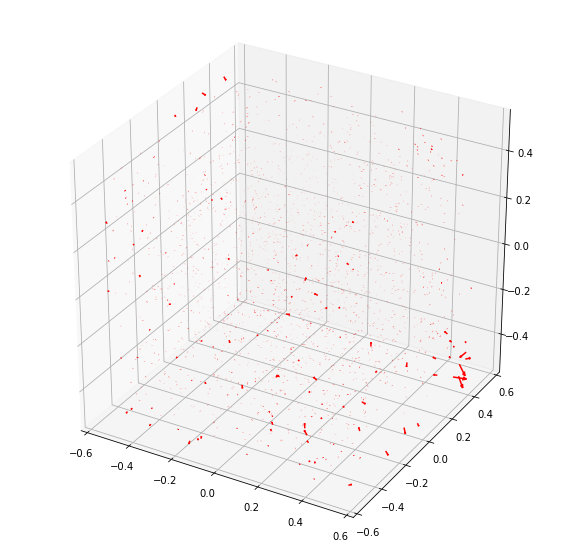

In [621]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')

x, y, z = np.meshgrid(np.arange(-0.8, 1, 0.2), np.arange(-0.8, 1, 0.2), np.arange(-0.8, 1, 0.8))

# grad = grad*5
ax.quiver(p_[:,0], p_[:,1], p_[:,2], grad[:,0], grad[:,1], grad[:,2], length=2, color = 'red')

plt.show()